In [34]:
from utils.load_results import *
from utils.plot_helpers import *
#from utils.analysis_from_interaction import error_analysis

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [18]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [13]:
datasets = ['(3,4)', ]
n_values = [4,]
n_attributes = [3, ]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [19]:
context_unaware = True # whether original or context_unaware simulations are evaluated
if context_unaware:
    setting = 'context_unaware'
else:
    setting = 'standard' # context-aware

## Accuracies

### Training trajectories

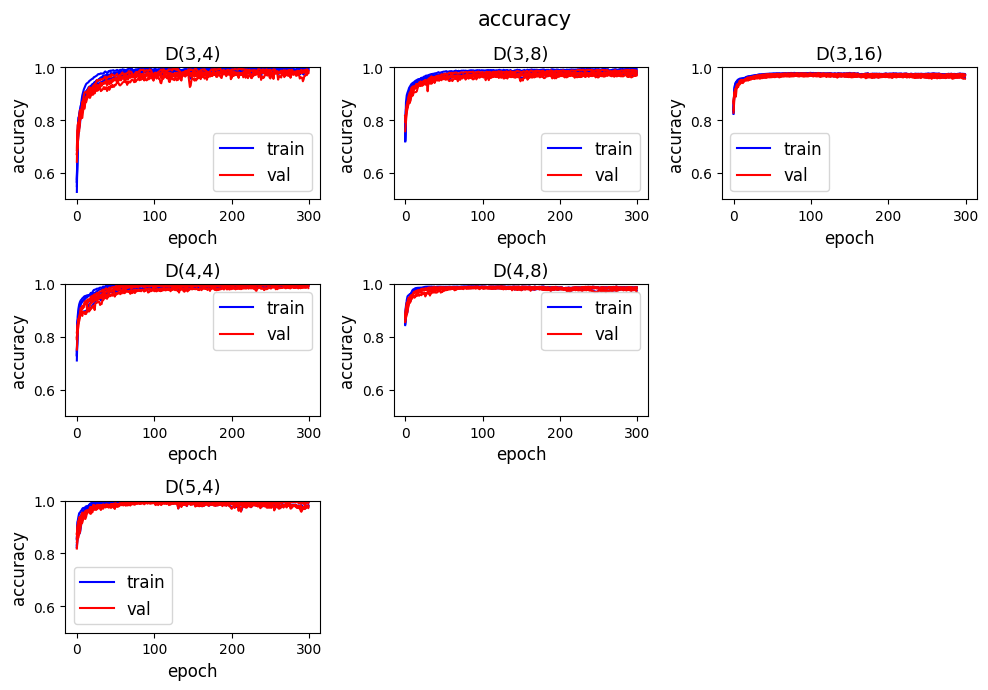

In [20]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.5, 1), steps=(1, 1))

### Learning speed

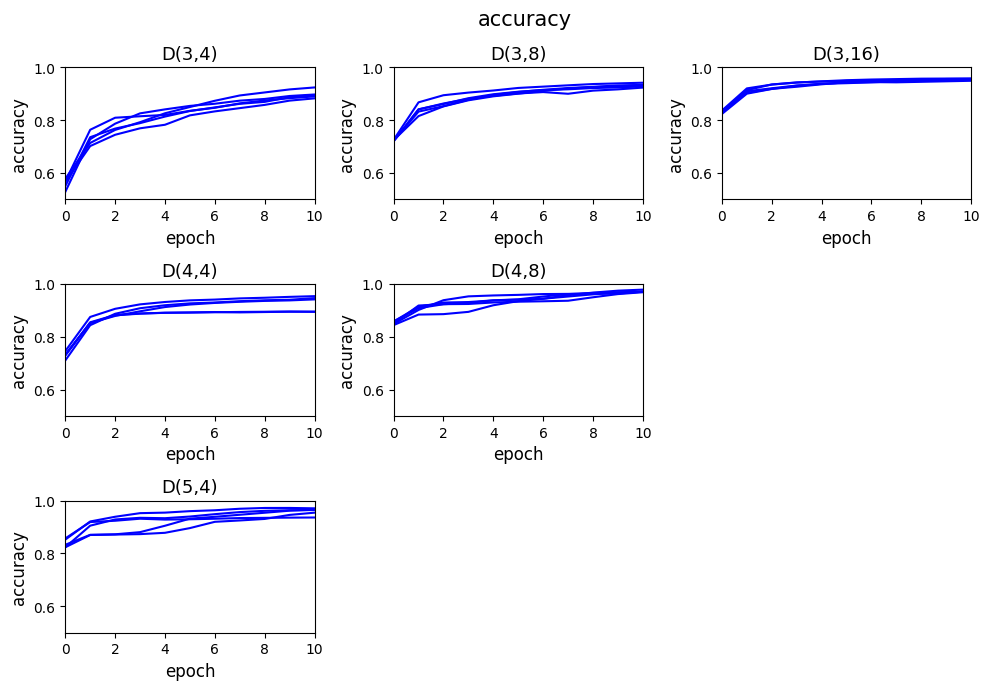

In [21]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), train_only=True)

### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [22]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False)
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc'],
              all_accuracies['cu_train_acc'], all_accuracies['cu_val_acc']]
test_accuracies = [all_accuracies['test_acc'], all_accuracies['cu_test_acc']]

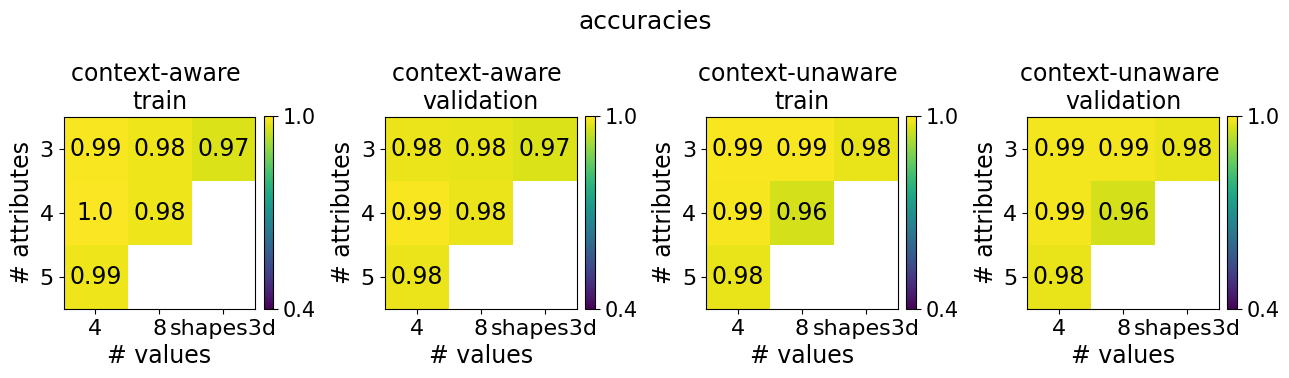

In [23]:
plot_heatmap(accuracies, 'mean', plot_dims=(1,4), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', 
             fontsize=17)

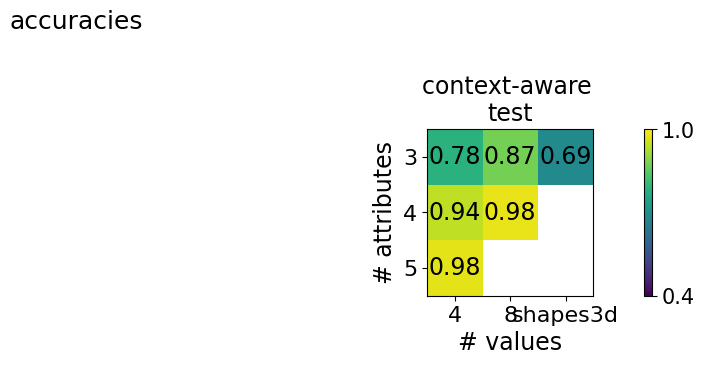

In [25]:
plot_heatmap(test_accuracies, 'mean', plot_dims=(1,1), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', titles=('context-aware \ntest', 'context'), 
             fontsize=17, matrix_indices=((0, 0), (0, 2), (0, 1), (1, 0), (2, 0), (1, 1)))

#### Context-unaware

In [26]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['cu_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.995, 0.002),
 '(3,8)': (0.993, 0.003),
 '(3,16)': (0.981, 0.007),
 '(4,4)': (0.992, 0.002),
 '(4,8)': (0.961, 0.011),
 '(5,4)': (0.98, 0.011)}

In [27]:
# context unaware
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['cu_val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.99, 0.003),
 '(3,8)': (0.989, 0.004),
 '(3,16)': (0.979, 0.008),
 '(4,4)': (0.989, 0.002),
 '(4,8)': (0.961, 0.011),
 '(5,4)': (0.979, 0.012)}

#### Context-aware

In [28]:
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.993, 0.003),
 '(3,8)': (0.984, 0.006),
 '(3,16)': (0.969, 0.005),
 '(4,4)': (0.995, 0.003),
 '(4,8)': (0.984, 0.004),
 '(5,4)': (0.985, 0.007)}

In [29]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.983, 0.004),
 '(3,8)': (0.977, 0.006),
 '(3,16)': (0.968, 0.006),
 '(4,4)': (0.993, 0.005),
 '(4,8)': (0.982, 0.006),
 '(5,4)': (0.984, 0.008)}

#### Accuracies: Boostrapped CIs

In [30]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# context-aware (train, val), context-unaware (train, val)
for i in range(len(accuracies)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies[i]) for _ in range(len(accuracies[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

Bootstrap Confidence Interval (95.0%): (0.9742289419074853, 0.9843448883758651), Mean: 0.9793044715697765
Bootstrap Confidence Interval (95.0%): (0.9674331623249584, 0.9837592766947216), Mean: 0.9761439937552843
Bootstrap Confidence Interval (95.0%): (0.9680440195370053, 0.9887717207592395), Mean: 0.9798617087530028
Bootstrap Confidence Interval (95.0%): (0.9686356779742572, 0.9886717819571496), Mean: 0.9798709879792927


### Test accuracies
means and stds

In [31]:
# first context-aware, then context-unaware
for cond in test_accuracies:
    for i, d in enumerate(datasets):
        print(d, round(np.mean(cond[i]), 3), round(np.std(cond[i]), 3), round(np.min(cond[i]), 2), round(np.max(cond[i]), 2))

(3,4) 0.784 0.035 0.73 0.83
(3,8) 0.686 0.061 0.62 0.78
(3,16) 0.874 0.007 0.86 0.88
(4,4) 0.942 0.048 0.87 0.98
(4,8) 0.976 0.007 0.96 0.98
(5,4) 0.979 0.01 0.97 0.99
(3,4) 0.84 0.036 0.79 0.88
(3,8) 0.778 0.068 0.65 0.83
(3,16) 0.896 0.005 0.89 0.9
(4,4) 0.922 0.028 0.88 0.96
(4,8) 0.943 0.012 0.93 0.95
(5,4) 0.964 0.014 0.94 0.98


## Entropy scores

In [35]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (6, 5) + inhomogeneous part.

### General

In [33]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores')

NameError: name 'entropies' is not defined

#### Means and stds

In [ ]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

#### Bootstraped CIs

In [ ]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for i in range(len(entropies)):
    score = list(entropy_scores.keys())[i]
    for idx, d in enumerate(datasets):
        for _ in range(num_bootstrap_samples):
            bootstrap_sample = [random.choice(entropies[i][idx]) for _ in range(len(entropies[i][idx]))]
            bootstrap_mean = np.mean(bootstrap_sample)
            bootstrap_means.append(bootstrap_mean)

        # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
        alpha = (1 - confidence_level) / 2
        lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
        upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
        #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
        entropies_bootstrapped[d + score] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped

### Concept-dependent

In [ ]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Concept-level

#### Plotting Concept-level

In [ ]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}


In [ ]:
all_hierarchical = {}
all_hierarchical['metric'] = ['Effectiveness'] * 150 + ['Consistency'] * 150 + ['NMI'] * 150 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

In [ ]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Concept Level', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

In [ ]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [ ]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [ ]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [1, 2, 3, 4, 5]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,3), round(upper_percentile,3)), round(np.mean(bootstrap_means),3)
entropies_bootstrapped
    

{1: ((nan, nan), nan),
 2: ((nan, nan), nan),
 3: ((nan, nan), nan),
 4: ((nan, nan), nan),
 5: ((nan, nan), nan)}

### Context-dependent

In [ ]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Context

In [ ]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [ ]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [ ]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [0, 1, 2, 3, 4]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped
    

#### Plotting per Context condition

In [ ]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [ ]:
all_context_dep = {}
all_context_dep['metric'] = ['Effectiveness'] * 150 + ['Consistency'] * 150 +['NMI'] * 150 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


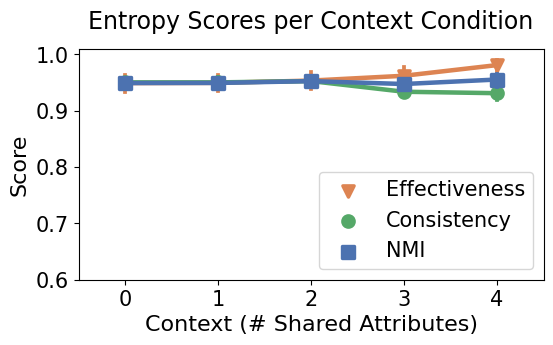

In [ ]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Context Condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

### Concept x Context

In [ ]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:137: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


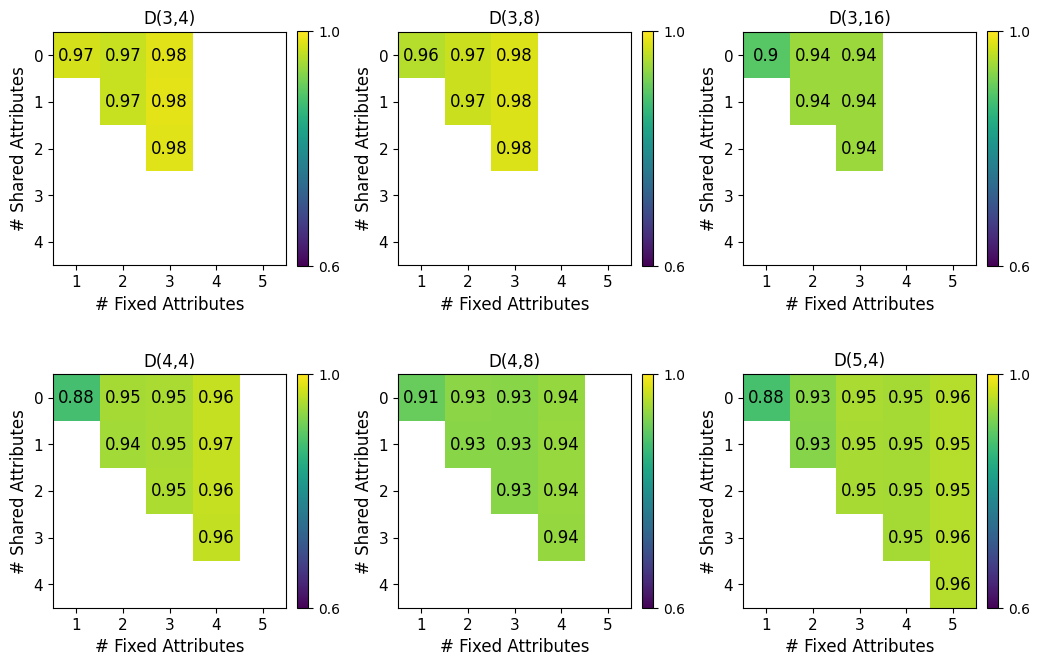

In [ ]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### effectiveness

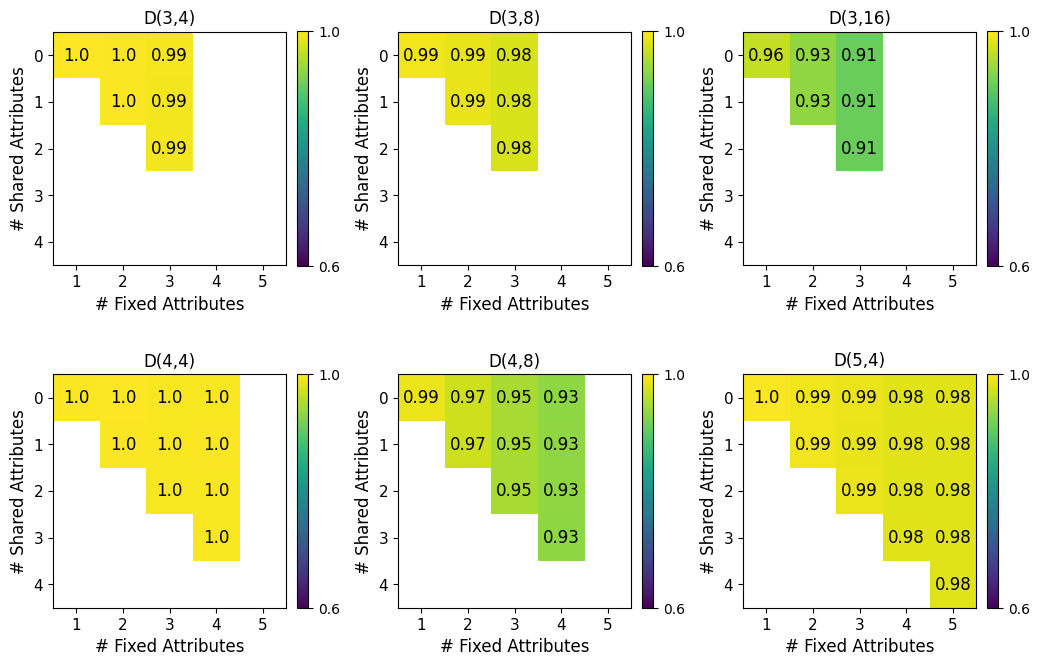

In [ ]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### consistency

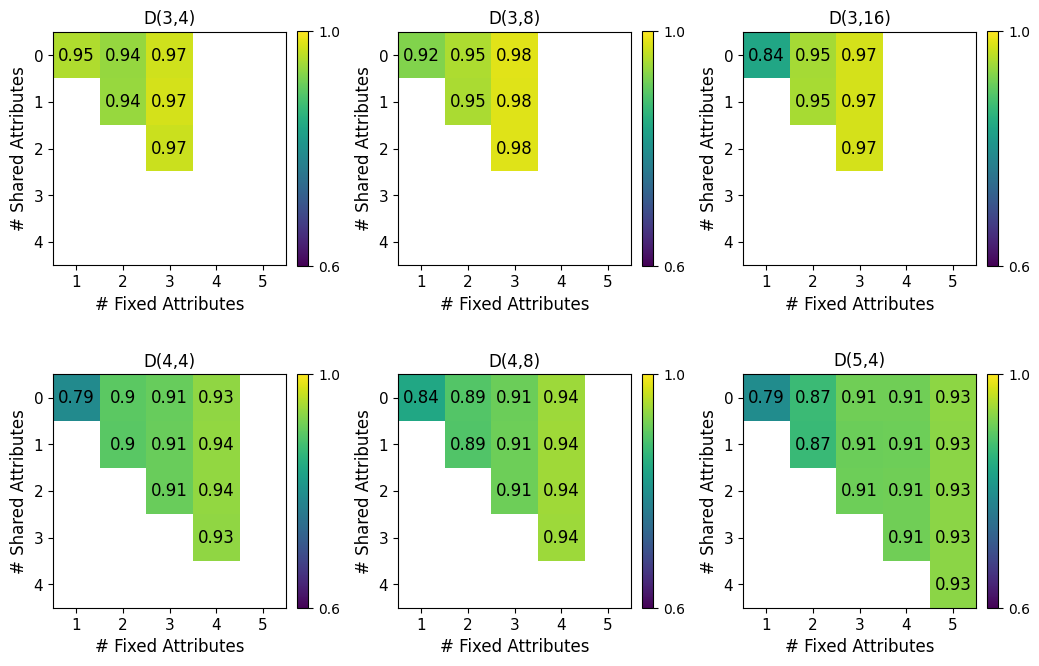

In [ ]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

## Message length

In [ ]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

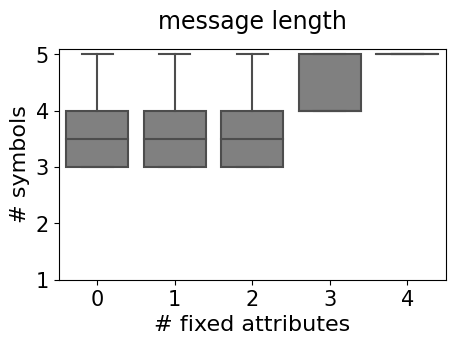

In [ ]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

## Symbol redundancy

In [ ]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

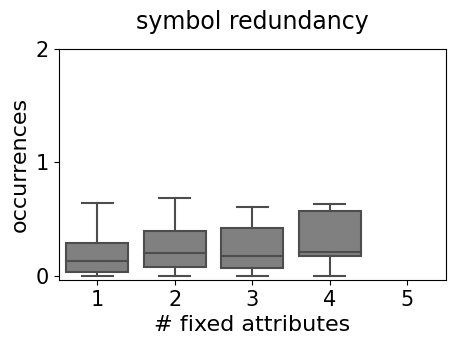

In [ ]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Compositionality

In [ ]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        posdis_generic[d, run] = disent_score['posdis_generic']
        bosdis_generic[d, run] = disent_score['bosdis_generic']

### Topsim

In [ ]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.46 sd 0.07
(3,8) topsim: 0.411 sd 0.06
(3,16) topsim: 0.287 sd 0.04
(4,4) topsim: 0.418 sd 0.04
(4,8) topsim: 0.336 sd 0.05
(5,4) topsim: 0.431 sd 0.06


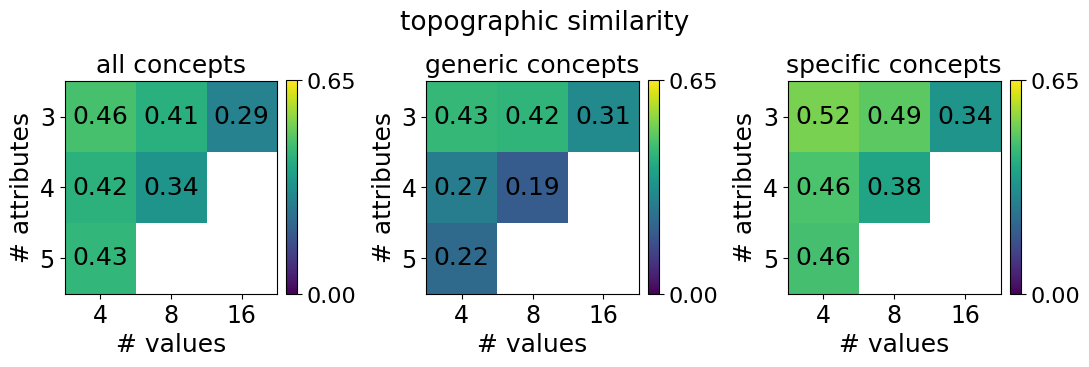

In [ ]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

### Posdis

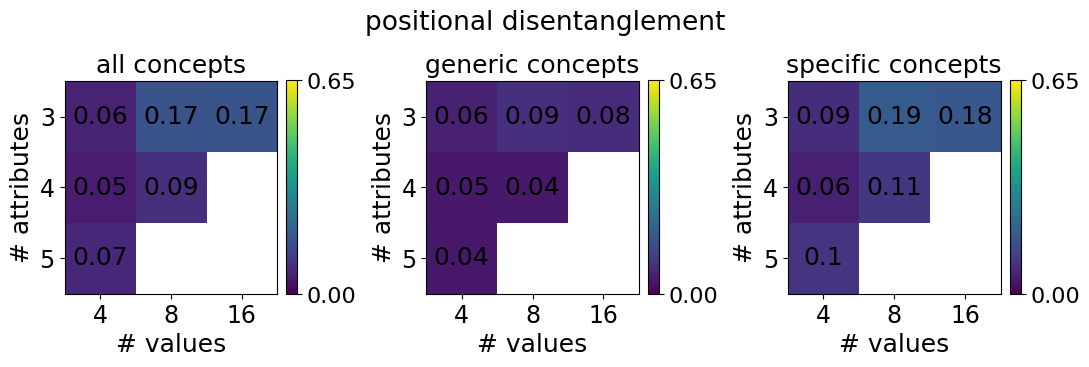

In [ ]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

### Bosdis

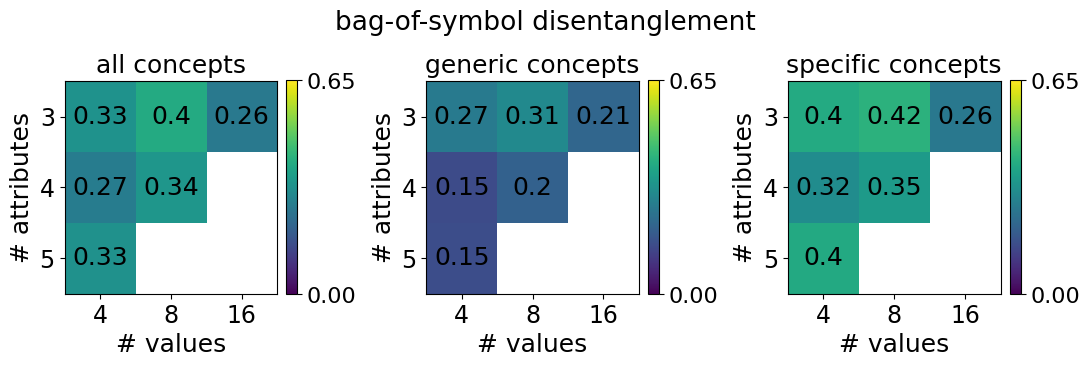

In [ ]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [ ]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:137: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


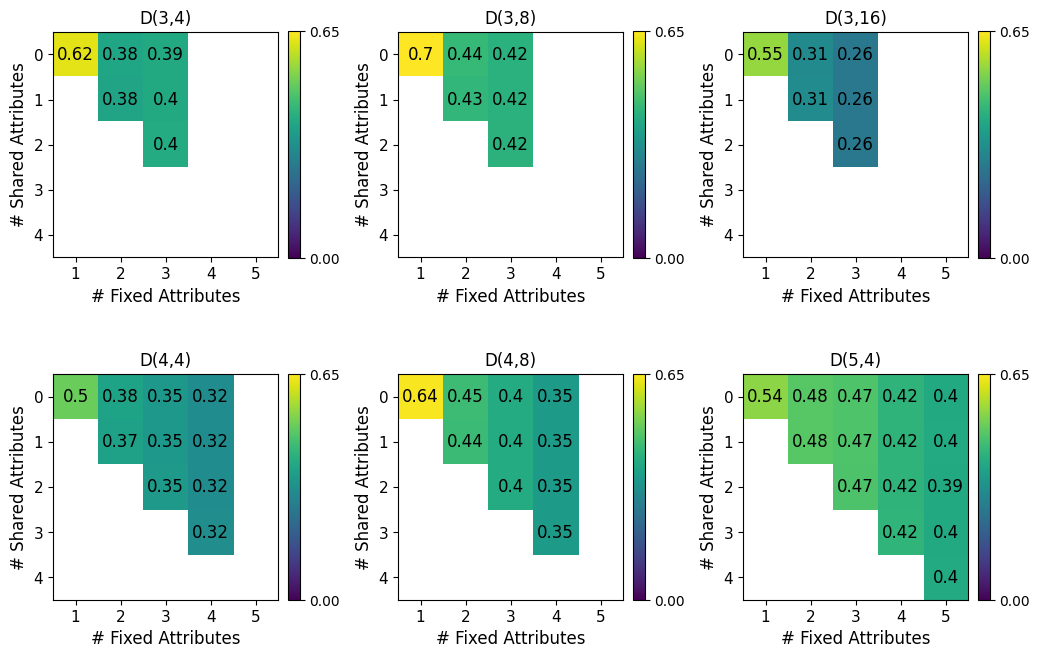

In [ ]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [ ]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

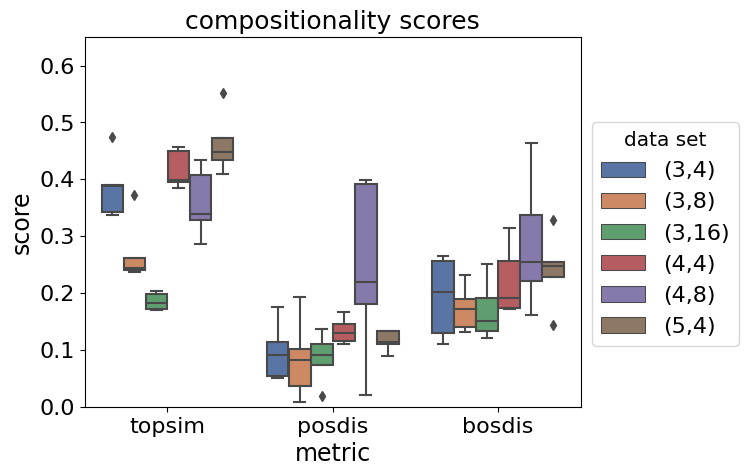

In [ ]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

## co-occurrences (not done yet)

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()